In [4]:
# import pertinent libraries
import os
import datetime
import glob as glob
import numpy as np
from keras.models import Model
from keras.layers import Input, add, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
img_width, img_height = 224, 224

train_dir = '/content/drive/MyDrive/Data_Sets_of_abnormality_in_large_intestine/nerthus_dataset/train'
validate_dir = '/content/drive/MyDrive/Data_Sets_of_abnormality_in_large_intestine/nerthus_dataset/val'
test_dir = '/content/drive/MyDrive/Data_Sets_of_abnormality_in_large_intestine/nerthus_dataset/test'
nb_epochs = 10
batch_size = 32
nb_classes = len(glob.glob(train_dir + '/*'))

# get number of images in training directory
nb_train_samples = 0
for r, dirs, files in os.walk(train_dir):
    for dr in dirs:
        nb_train_samples += len(glob.glob(os.path.join(r, dr + "/*")))
# get number of images in validation directory
nb_validate_samples = 0
for r, dirs, files in os.walk(validate_dir):
    for dr in dirs:
        nb_validate_samples += len(glob.glob(os.path.join(r, dr + "/*")))
# get the number of images in test directory
nb_test_samples = 0
for r, dirs, files in os.walk(test_dir):
    for dr in dirs:
        nb_test_samples += len(glob.glob(os.path.join(r, dr + "/*")))

In [6]:
print(nb_classes)

4


In [7]:
# Data preprocessing for training
train_datagen =  ImageDataGenerator(
    rotation_range = 20,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [8]:
# data pre-processing for validation
validate_datagen =  ImageDataGenerator(
    rotation_range = 20,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [9]:
# data pre-processing for testing
test_datagen =  ImageDataGenerator(
    rotation_range = 20,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [10]:
# generate and store training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 4420 images belonging to 4 classes.


In [11]:
# generate and store validation data
validate_generator = validate_datagen.flow_from_directory(
    validate_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 552 images belonging to 4 classes.


In [12]:
# generate and store test data
test_generator = validate_datagen.flow_from_directory(
    test_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 553 images belonging to 4 classes.


In [13]:
# building model
resnet_101_model = Sequential()

pretrained_model= tf.keras.applications.ResNet101(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=8,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_101_model.add(pretrained_model)
resnet_101_model.add(Flatten())
resnet_101_model.add(Dense(512, activation='relu'))
resnet_101_model.add(Dropout(0.5))
resnet_101_model.add(Dense(4, activation='softmax'))

171446536/171446536 [==============================] - 2s 0us/step


In [14]:
resnet_101_model.compile(Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [15]:
resnet_101_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 2048)              42658176  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 43,709,316
Trainable params: 1,051,140
Non-trainable params: 42,658,176
_________________________________________________________________


In [16]:
# fit the model, log the results and the training time
now = datetime.datetime.now
t = now()
history = resnet_101_model.fit_generator(
    train_generator,
    epochs = nb_epochs,
    steps_per_epoch = nb_train_samples//batch_size,
    validation_data = validate_generator,
    validation_steps = nb_validate_samples//batch_size)
print('Training time: %s' % (now() - t))

<ipython-input-16-287188d3be17>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = resnet_101_model.fit_generator(


Epoch 1/10
138/138 [==============================] - 1585s 11s/step - loss: 0.5163 - accuracy: 0.8079 - val_loss: 0.1757 - val_accuracy: 0.9559
Epoch 2/10
138/138 [==============================] - 1504s 11s/step - loss: 0.1625 - accuracy: 0.9524 - val_loss: 0.0973 - val_accuracy: 0.9761
Epoch 3/10
138/138 [==============================] - 1517s 11s/step - loss: 0.1077 - accuracy: 0.9711 - val_loss: 0.0710 - val_accuracy: 0.9871
Epoch 4/10
138/138 [==============================] - 1513s 11s/step - loss: 0.0745 - accuracy: 0.9811 - val_loss: 0.0571 - val_accuracy: 0.9853
Epoch 5/10
138/138 [==============================] - 1504s 11s/step - loss: 0.0559 - accuracy: 0.9861 - val_loss: 0.0509 - val_accuracy: 0.9853
Epoch 6/10
138/138 [==============================] - 1512s 11s/step - loss: 0.0451 - accuracy: 0.9886 - val_loss: 0.0432 - val_accuracy: 0.9890
Epoch 7/10
138/138 [==============================] - 1507s 11s/step - loss: 0.0393 - accuracy: 0.9907 - val_loss: 0.0366 - val_ac

In [17]:
model = resnet_101_model.save("ResNet101_Nurthus_Dataset.h5")

In [18]:
from keras import models
model = models.load_model("ResNet101_Nurthus_Dataset.h5")

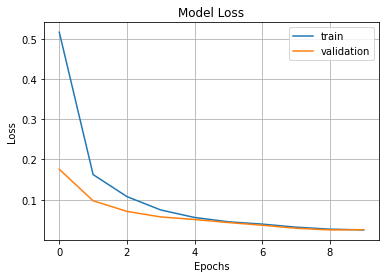

In [19]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.grid()
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "validation"])
plt.show()

In [20]:
X_test, Y_test = next(test_generator)

In [ ]:
print(X_test,Y_test)

In [22]:
y_true=[]
for i in range(len(Y_test)):
    K= Y_test[i]
    
    y_true.append(list(K).index(max(list(K))))

In [23]:
print(y_true)

[1, 3, 1, 3, 1, 1, 1, 0, 3, 1, 1, 0, 1, 2, 1, 3, 3, 2, 1, 1, 2, 3, 0, 0, 1, 3, 3, 2, 1, 2, 2, 3]


In [24]:
M = resnet_101_model.predict(X_test)
X_t=[]
for i in range(len(M)):
    K= M[i]
    X_t.append(list(K).index(max(list(K))))

1/1 [==============================] - 11s 11s/step


In [25]:
print(X_t)

[1, 3, 1, 3, 1, 1, 1, 0, 3, 1, 1, 0, 1, 2, 1, 3, 3, 2, 1, 1, 2, 3, 0, 2, 1, 3, 3, 2, 1, 2, 2, 3]


In [26]:
print(classification_report(y_true, X_t, zero_division = 0))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       1.00      1.00      1.00        13
           2       0.86      1.00      0.92         6
           3       1.00      1.00      1.00         9

    accuracy                           0.97        32
   macro avg       0.96      0.94      0.95        32
weighted avg       0.97      0.97      0.97        32



In [27]:
print(confusion_matrix(y_true,X_t))

[[ 3  0  1  0]
 [ 0 13  0  0]
 [ 0  0  6  0]
 [ 0  0  0  9]]
